# Sweeping Parameters

In [ ]:
# download modsim.py if necessary

from os.path import exists

filename = 'modsim.py'
if not exists(filename):
    from urllib.request import urlretrieve
    url = 'https://raw.githubusercontent.com/AllenDowney/ModSim/main/'
    local, _ = urlretrieve(url+filename, filename)
    print('Downloaded ' + local)

In [1]:
import numpy
from matplotlib import pyplot
%matplotlib inline
%config InlineBackend.figure_format = "retina"

import modsim

In [3]:
def make_system(beta, gamma):
    init = modsim.State(s=89, i=1, r=0)
    init /= init.sum()

    return modsim.System(
        init=init, t_end=7*14,
        beta=beta, gamma=gamma,
    )

def update_func(t, state, system):
    s, i, r = state.s, state.i, state.r

    infected = system.beta * i * s    
    recovered = system.gamma * i
    
    s -= infected
    i += infected - recovered
    r += recovered
    
    return modsim.State(s=s, i=i, r=r)

def run_simulation(system, update_func):
    frame = modsim.TimeFrame(columns=system.init.index)
    frame.loc[0] = system.init
    
    for t in range(0, system.t_end):
        frame.loc[t+1] = update_func(t, frame.loc[t], system)
    
    return frame

def calc_total_infected(results, system):
    s_0 = results.s[0]
    s_end = results.s[system.t_end]
    return s_0 - s_end

### Sweeping Beta

In [2]:
beta_array = numpy.linspace(0.1, 1.1, 11)
gamma = 0.25

In [4]:
def sweep_beta(beta_array, gamma):
    sweep = modsim.SweepSeries()
    for beta in beta_array:
        system = make_system(beta, gamma)
        results = run_simulation(system, update_func)
        sweep[beta] = calc_total_infected(results, system)
    return sweep

In [5]:
infected_sweep = sweep_beta(beta_array, gamma)

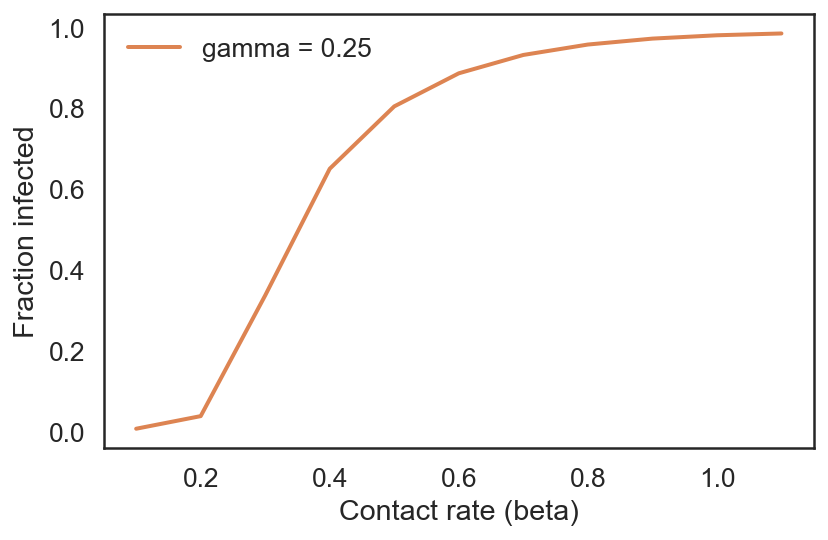

In [6]:
infected_sweep.plot(label=f'gamma = {gamma}', color='C1')

modsim.decorate(xlabel='Contact rate (beta)',
         ylabel='Fraction infected')

### Sweeping Gamma

In [7]:
gamma_array = numpy.linspace(0.1, 0.7, 4)
gamma_array

array([0.1, 0.3, 0.5, 0.7])

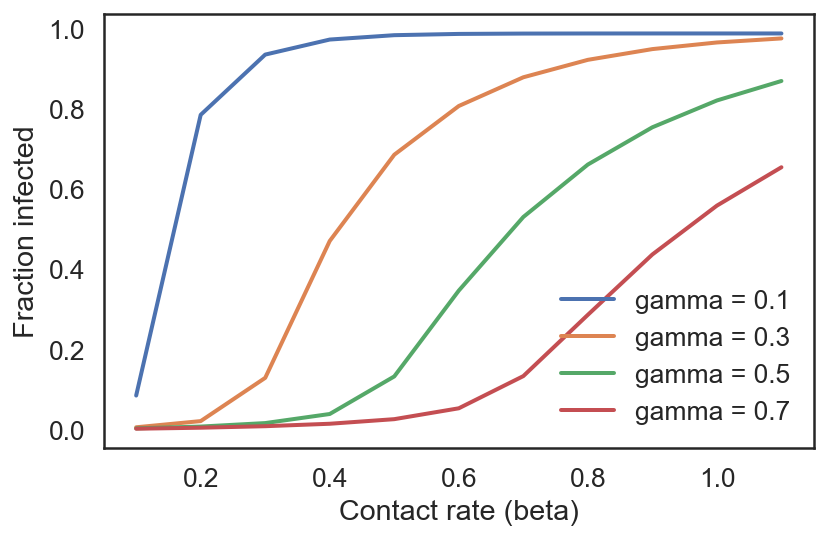

In [9]:
for gamma in gamma_array:
    infected_sweep = sweep_beta(beta_array, gamma)
    infected_sweep.plot(label=f'gamma = {gamma}')
    
modsim.decorate(xlabel='Contact rate (beta)',
         ylabel='Fraction infected')

### Using a SweepFrame

In [10]:
def sweep_parameters(beta_array, gamma_array):
    frame = modsim.SweepFrame(columns=gamma_array)
    for gamma in gamma_array:
        frame[gamma] = sweep_beta(beta_array, gamma)
    return frame

In [11]:
frame = sweep_parameters(beta_array, gamma_array)

In [12]:
frame.head()

,0.1,0.3,0.5,0.7
0.1,0.084693,0.005444,0.002736,0.001827
0.2,0.785673,0.020878,0.007235,0.004367
0.3,0.936118,0.128878,0.015929,0.008129
0.4,0.973692,0.470707,0.038603,0.014242
0.5,0.984596,0.686050,0.132438,0.025708


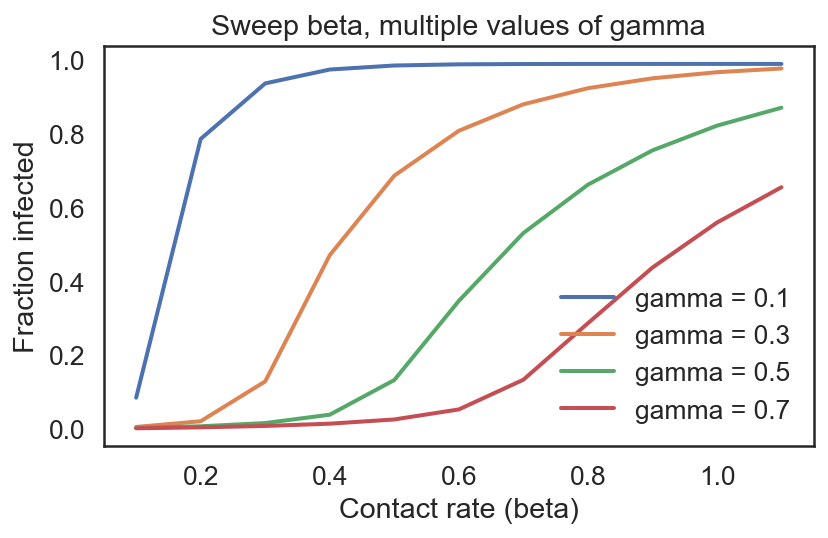

In [13]:
for gamma in gamma_array:
    frame[gamma].plot(label=f'gamma = {gamma}')

modsim.decorate(xlabel='Contact rate (beta)',
         ylabel='Fraction infected',
         title='Sweep beta, multiple values of gamma')

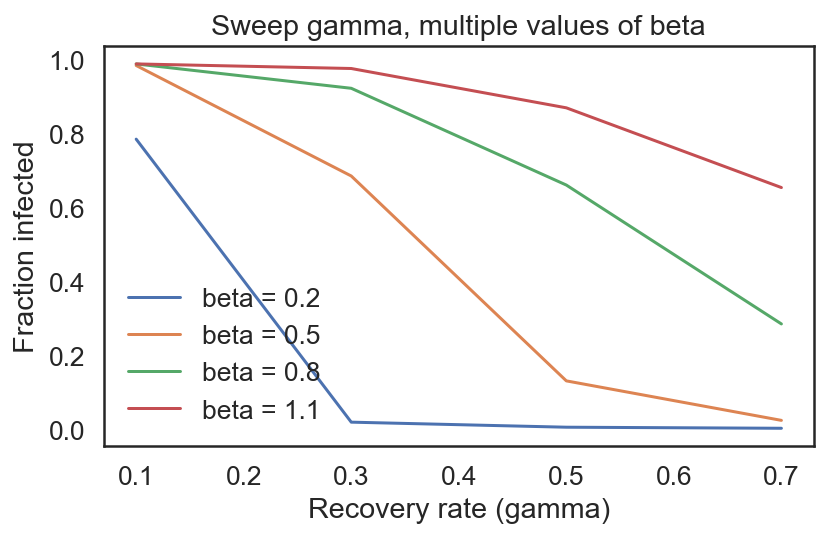

In [14]:
for beta in [0.2, 0.5, 0.8, 1.1]:
    frame.loc[beta].plot(label=f'beta = {beta}')
    
modsim.decorate(xlabel='Recovery rate (gamma)',
         ylabel='Fraction infected',
         title='Sweep gamma, multiple values of beta')

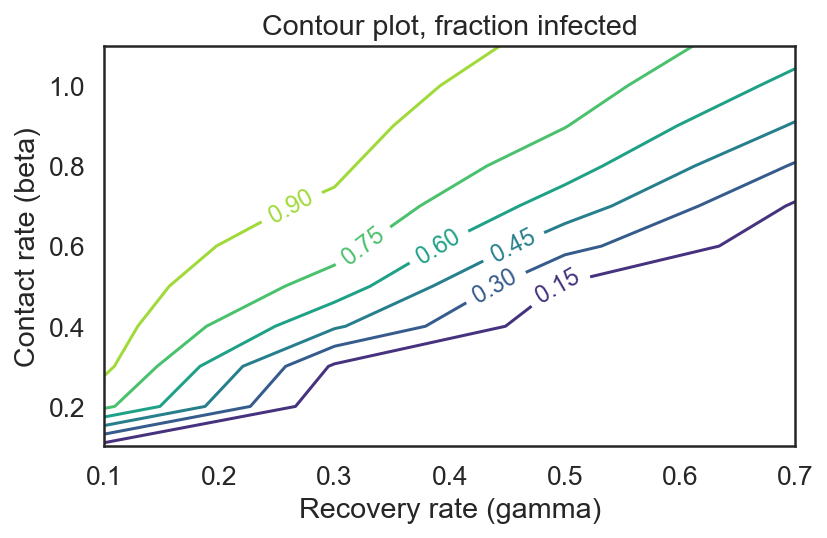

In [15]:
modsim.contour(frame)

modsim.decorate(xlabel='Recovery rate (gamma)',
         ylabel='Contact rate (beta)',
         title='Contour plot, fraction infected')

### Exercise 1
If we know `beta` and `gamma`, we can compute the fraction of the population that gets infected.
In general, we don’t know these parameters, but sometimes we can estimate them based on the behavior of an outbreak.

Suppose the infectious period for the Freshman Plague is known to be 2 days on average, and suppose during one particularly bad year, 40% of the class is infected at some point. Estimate the time between contacts, `1/beta`.

In [16]:
gamma = 1/2
infected_sweep = sweep_beta(beta_array, gamma)
infected_sweep

,values
0.1,0.002736
0.2,0.007235
0.3,0.015929
0.4,0.038603
0.5,0.132438
0.6,0.346765
0.7,0.530585
0.8,0.661553
0.9,0.754595
1.0,0.821534


In [17]:
# Interpolating by eye, we can see that the infection rate passes 
# through 0.4 when beta is between 0.6 and 0.7
# We can use the `crossings` function to interpolate more precisely
# (although we don't know about it yet :)

beta_estimate = modsim.crossings(infected_sweep, 0.4)
beta_estimate

array([0.62548698])

In [19]:
# Time between contacts is 1/beta

tc = 1/beta_estimate # tc
tc

array([1.59875429])